In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from collections import defaultdict
from schedules import ScheduleSampler

## Block-level assign-and-adjust
In this notebook, we study the extension of the assign-and-adjust model to a block-level schedule. (We specifically use 3 blocks per day, roughly corresponding to the morning, afternoon, and evening.) In an effort to produce a more reasonable estimate of student and staff schedules, we introduce the `ScheduleSampler` wrapper class for representing cohorts.

Rather than using hill-climbing to adjust the solution for block-to-block balance, we use a greedy algorithm that maintains approximate balance at each step. Optimal spacing is still guaranteed.

In [2]:
n_days = 7
n_blocks = 3
min_distance = 3     # in blocks
test_interval = 3.5  # in days
n_tests = n_days / test_interval
buffer = .1
n_people = 10000

## Tiered sampling
This is a 0th-order estimate of what schedules might look like at Tufts. We assume students (most of the population) are usually available from day to day but are rather busy and therefore have a $\frac{1}{3}$ probability of being available in a particular block. Faculty and staff do not live on campus and therefore are available on fewer days, but out of necessity are usually available for testing in the blocks they *are* on campus.

In [3]:
sampler = ScheduleSampler(
    cohorts={
        'Students': {
            'weight': 5000,
            'schedules': {
                '1111111': 0.7,   # available always
                '1010111': 0.15,  # M/W/F/weekends
                '0101011': 0.15   # Tu/Th/weekends
            },
            'blocks': [1/3, 1/3, 1/3]
        },
        'High-frequency staff': {
            'weight': 500,
            'schedules': {
                '{:07b}'.format(i << 2): 1
                for i in range(2 ** 5) if '{:b}'.format(i).count('1') == 2
            },  # 2 weekdays
            'blocks': [3/4, 1/2, 3/4]
        },
        'Low-frequency staff': {
            'weight': 500,
            'schedules': {
                '{:07b}'.format(i << 2): 1
                for i in range(2 ** 5) if '{:b}'.format(i).count('1') == 1
            },  # 1 weekday
            'blocks': [3/4, 1/2, 3/4]
        }
    },
    n_days=n_days,
    n_blocks=n_blocks
)

In [4]:
person_schedules = sampler.sample(n_people)

In [5]:
def greedy_with_balance(person_schedules, n_days, n_blocks, n_tests, min_distance):
    """Assigns people to optimal test schedules while attempting
    to keep all blocks balanced.
    """
    interval = (n_days * n_blocks) / n_tests
    test_schedules = np.zeros_like(person_schedules)
    n_no_schedule = 0
    block_counts = np.zeros(n_days * n_blocks)
    tests_assigned = 0
    
    for person_idx, person in enumerate(person_schedules):
        avail = np.sort(np.where(person == 1)[0])
        pairs = {}
        person_tests = n_tests
        # TODO: Enumeration hardcoded for two tests.
        for a_idx, outer in enumerate(avail):
            for inner in avail[a_idx + 1:]:
                if inner - outer >= min_distance:
                    penalty = ((inner - outer) - interval)**2
                    pairs[(outer, inner)] = penalty
        if not pairs and len(avail) >= 1:
            # The person is available during exactly one block or
            # is available only in a series of blocks that are not
            # spaced apart enough to warrant multiple tests.
            person_tests = 1
            for b in avail:
                pairs[(b, b)] = 0  # spacing cost not applicable
            
        if pairs:
            # Choose an optimal pair that gives the best balance.
            best_spacing_cost = min(pairs.values())
            spaced_pairs = [p for p, c in pairs.items()
                            if c == best_spacing_cost]
            
            expected_load_old = tests_assigned / n_blocks
            expected_load_new = (tests_assigned + person_tests) / n_blocks 
            balance_costs = {
                p: sum((block_counts[b] + 1 - expected_load_new)**2 -
                       (block_counts[b] - expected_load_old)**2
                       for b in p)
                for p in spaced_pairs
            }
            best_balance_cost = min(balance_costs.values())
            balanced_pairs = [p for p, c in balance_costs.items()
                              if c == best_balance_cost]
            pair = choice(balanced_pairs)
            for b in pair:
                test_schedules[person_idx, b] = 1
                block_counts[b] += 1
            tests_assigned += person_tests
        else:
            n_no_schedule += 1
    if n_no_schedule:
        print(f'Warning: no testing schedule assigned for {n_no_schedule} people',
              '(not enough availability)')
    return test_schedules

In [6]:
np.random.shuffle(person_schedules)
test_schedules = greedy_with_balance(person_schedules,
                                     n_days,
                                     n_blocks,
                                     n_tests,
                                     min_distance)

expected_load = test_schedules.sum() / (n_blocks * n_days)
max_deviation = 100 * np.max(np.abs(test_schedules.sum(axis=0) - expected_load)) / expected_load
print('Max deviation: {:.2f}%'.format(max_deviation))

Max deviation: 8.54%


In [7]:
test_schedules.sum(axis=0)

array([836, 903, 913, 836, 905, 928, 890, 921, 901, 927, 897, 860, 923,
       890, 821, 924, 913, 912, 908, 916, 927])

In [8]:
gaps = []
for sched in test_schedules:
    on = np.where(sched == 1)[0]
    if len(on) > 1:
        gaps.append(np.max(on) - np.min(on))
gaps_bins = np.arange(min_distance, n_blocks * n_days - 1) / n_blocks

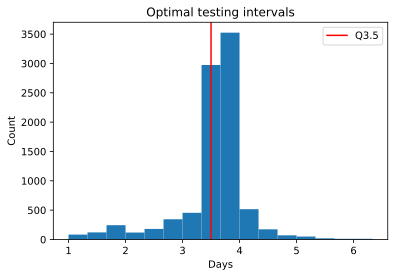

In [9]:
plt.hist(np.array(gaps) / 3, bins=gaps_bins)
plt.axvline(n_days / n_tests, color='red', label=f'Q{n_days / n_tests}')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Optimal testing intervals')
plt.show()